# Сравнение AMM vs MM (парные тесты)
Набор: один ценовой шок −10%, 10 000 повторов (режимы mm и amm). Файл данных: `results/summary.csv`.

In [ ]:
import sys
from pathlib import Path
import os
import importlib.util

cwd = Path(os.getcwd()).resolve()
repo_root = cwd
for parent in [cwd] + list(cwd.parents):
    if (parent / "AgentBasedModel").exists():
        repo_root = parent
        break

if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
repo_root

math_path = repo_root / "AgentBasedModel" / "utils" / "math.py"
spec = importlib.util.spec_from_file_location("math_local", math_path)
math_local = importlib.util.module_from_spec(spec)
spec.loader.exec_module(math_local)
paired_ttest = math_local.paired_ttest

In [21]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

summary_path = (repo_root / "results" / "summary.csv").resolve()
if not summary_path.exists():
    raise FileNotFoundError(summary_path)

df = pd.read_csv(summary_path)
df.head()

,scenario_id,scenario_run_id,scenario_type,agent_preset,mode,shock_value,shock_value_kind,repeat_idx,seed,panic_detected,...,p_at_t_end,p_right_before,p_right_after,plot_files,n_random,n_fundamentalist,n_chartist,n_universalist,n_marketmaker,n_automarketmaker
0,price_baseline_mm_10,price_baseline_mm_10_run1,price,baseline,mm,10,percent,1,124,False,...,92.7,96.5,96.0,NaN,10,10,10,10,1,0
1,price_baseline_mm_10,price_baseline_mm_10_run2,price,baseline,mm,10,percent,2,125,False,...,102.7,112.8,112.6,NaN,10,10,10,10,1,0
2,price_baseline_mm_10,price_baseline_mm_10_run3,price,baseline,mm,10,percent,3,126,False,...,77.8,89.7,89.7,NaN,10,10,10,10,1,0
3,price_baseline_mm_10,price_baseline_mm_10_run4,price,baseline,mm,10,percent,4,127,False,...,97.3,105.1,105.3,NaN,10,10,10,10,1,0
4,price_baseline_mm_10,price_baseline_mm_10_run5,price,baseline,mm,10,percent,5,128,False,...,84.7,92.4,92.3,NaN,10,10,10,10,1,0


## Подготовка: фильтр и сведение в wide
- Берём только price-шок 10%
- Выравниваем AMM и MM по `repeat_idx`
- Метрики: `shock_duration`, `p_star`, `p_at_t_end`

In [22]:
df_price = df[df["scenario_id"].str.contains("price_baseline_")]
amm = df_price[df_price["mode"] == "amm"]
mm = df_price[df_price["mode"] == "mm"]

merged = pd.merge(amm, mm, on="repeat_idx", suffixes=("_amm", "_mm"))
merged.shape

(10000, 49)

## Парный t‑тест и эффект размера
- t‑test для пар
- Cohen's d для пар: mean(diff)/std(diff)
- 95% CI разности (уже в `paired_ttest`)

In [23]:
metrics = ["shock_duration", "p_star", "p_at_t_end"]
results = []

for m in metrics:
    a = merged[f"{m}_amm"]
    b = merged[f"{m}_mm"]
    diff = a - b
    t_res = paired_ttest(a, b)
    d_cohen = diff.mean() / diff.std(ddof=1)
    t_res["cohen_d"] = d_cohen
    t_res["metric"] = m
    results.append(t_res)

pd.DataFrame(results)[["metric","n","mean_diff","ci_low","ci_high","t_stat","p_value","cohen_d"]]

,metric,n,mean_diff,ci_low,ci_high,t_stat,p_value,cohen_d
0,shock_duration,9926,-8.754785,-10.101846,-7.407724,-12.739703,6.913621e-37,-0.127871
1,p_star,9926,-0.498883,-0.747918,-0.249848,-3.926804,8.666443e-05,-0.039414
2,p_at_t_end,9926,-0.641447,-0.863754,-0.419139,-5.655978,1.592521e-08,-0.056770


## Оценка разброса (среднее и стандартное отклонение)
Смотрим средние и SD по режимам, а также SD разностей (шум пары).

In [24]:
rows = []
for m in metrics:
    a = merged[f"{m}_amm"]
    b = merged[f"{m}_mm"]
    diff = a - b
    rows.append({
        "metric": m,
        "mean_amm": a.mean(), "sd_amm": a.std(ddof=1),
        "mean_mm": b.mean(), "sd_mm": b.std(ddof=1),
        "mean_diff": diff.mean(), "sd_diff": diff.std(ddof=1)
    })

pd.DataFrame(rows)

,metric,mean_amm,sd_amm,mean_mm,sd_mm,mean_diff,sd_diff
0,shock_duration,59.653392,40.705157,68.332863,55.302207,-8.754785,68.465743
1,p_star,92.201983,8.602203,92.704567,9.341111,-0.498883,12.657461
2,p_at_t_end,91.526096,7.589084,92.167499,8.406905,-0.641447,11.299000


## Непараметрический контроль
Для проверки устойчивости выводов можно посмотреть Wilcoxon по разностям.

In [25]:
rows = []
for m in metrics:
    a = merged[f"{m}_amm"]
    b = merged[f"{m}_mm"]
    diff = a - b
    stat, p = stats.wilcoxon(diff.dropna())
    rows.append({"metric": m, "wilcoxon_stat": stat, "p_value": p, "n": diff.dropna().shape[0]})
pd.DataFrame(rows)

,metric,wilcoxon_stat,p_value,n
0,shock_duration,21134269.5,3.929486e-25,9926
1,p_star,23494176.5,6.555264e-05,9926
2,p_at_t_end,22932956.5,3.911566e-08,9926


## Визуализация
- boxplot по метрикам для AMM и MM
- гистограмма разностей (AMM − MM)

In [27]:
%matplotlib inline

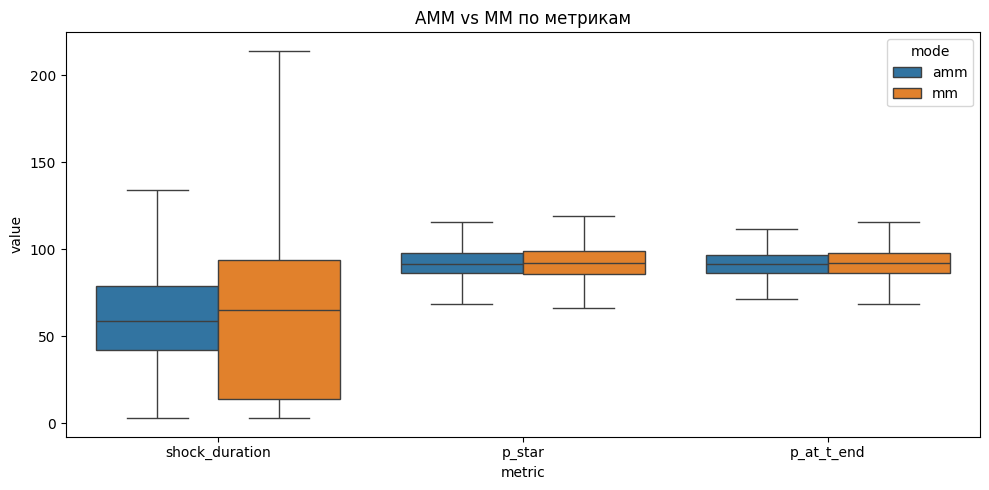

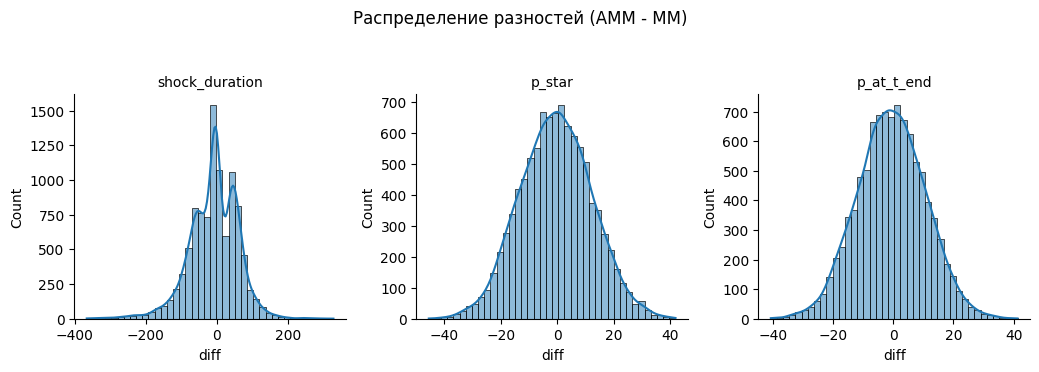

In [29]:
tidy = []
for m in metrics:
    tidy.append(pd.DataFrame({"metric": m, "mode": "amm", "value": merged[f"{m}_amm"]}))
    tidy.append(pd.DataFrame({"metric": m, "mode": "mm",  "value": merged[f"{m}_mm"]}))
tidy = pd.concat(tidy, ignore_index=True)

plt.figure(figsize=(10, 5))
sns.boxplot(data=tidy, x="metric", y="value", hue="mode", showfliers=False)
plt.title("AMM vs MM по метрикам")
plt.tight_layout()
plt.show()

diff_rows = []
for m in metrics:
    diff_rows.append(pd.DataFrame({"metric": m, "diff": merged[f"{m}_amm"] - merged[f"{m}_mm"]}))
diff_df = pd.concat(diff_rows, ignore_index=True)

g = sns.FacetGrid(diff_df, col="metric", sharex=False, sharey=False, height=3.5)
g.map_dataframe(sns.histplot, x="diff", kde=True, bins=40)
g.set_titles(col_template="{col_name}")
plt.suptitle("Распределение разностей (AMM - MM)", y=1.05)
plt.tight_layout()
plt.show()

## Быстрый вывод
Значения `mean_diff < 0` означают, что AMM даёт меньшие значения метрики, чем MM (например, меньшее время восстановления). Все p‑value << 0.05 — различия статистически значимы.